In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.stats import binned_statistic

from tqdm import tqdm

import sys
sys.path.append('../../src/')
from aDNA_coal_sim import *

%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True

# Deboxing a particular axis
def debox(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

from tqdm import tqdm
main_figdir = '../../plots/two_locus_stats/'
supp_figdir = '../../plots/supp_figs/two_locus_stats/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

# Computing Linkage Disequilibrium with Time-Stratified Samples

In [3]:
# 1. Defining the underlying functions that we would need
u200 = lambda rho : (rho**2 + 14*rho + 36) / (rho**2 + 13*rho + 18)
u111 = lambda rho : (rho**2 + 13*rho + 24) / (rho**2 + 13*rho + 18)
u022 = lambda rho : (rho**2 + 13*rho + 22) / (rho**2 + 13*rho + 18)

p111 = lambda r, t : r*(1.  - np.exp(-t*(r/2 + 1.)))/(r + 2)

# function for sigma2d 
def sigma2d(rho, t):
    ed2 = u200(rho) - 2*u111(rho) + u022(rho)
    gs = p111(rho,t)
    denom = (1 - gs)*u022(rho) + gs*u111(rho)
    return(ed2/denom)

# Defining sigma2d in the case without temporal sampling
sigma2d_const = lambda rho : (10 + rho)/(22 + 13*rho + rho**2)

# computing the relative error here
rel_err = lambda x, x_hat: (x_hat - x)/(x)

max_rel_err = lambda rho : (2.*rho)/(rho**3 + 15*rho**2 + 50*rho + 44.)

CPU times: user 905 ms, sys: 76.8 ms, total: 981 ms
Wall time: 1.68 s


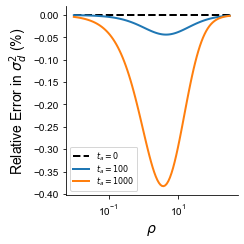

In [4]:
%%time
rhos = 10**np.linspace(-2,2.5, 100)
tas = np.array([0.01, 0.1])

Ne=1e4

f, ax = plt.subplots(1,1, figsize=(3.5,3.5), sharex=True, sharey=True)
sigma2d_const_realized = sigma2d_const(rhos)
ax.plot(rhos, rel_err(sigma2d_const_realized, sigma2d_const_realized), 
        lw=2, linestyle='--', color='black', label=r'$t_a = 0$')

for t in tas:
    cur_sigma2d = sigma2d(rhos, t)
    ax.plot(rhos, rel_err(sigma2d_const_realized, cur_sigma2d) * 100, lw=2, label=r'$t_a = %d$' % int(t*1e4))
    
ax.legend(fontsize=8, labelspacing=0.0)
# ax.set_xlabel(r'$\rho$', fontsize=14)
ax.set_ylabel(r'Relative Error in $\sigma^2_d$ (%)', fontsize=14)
ax.set_xscale('log'); 
ax.set_xlabel(r'$\rho$', fontsize=14)
debox(ax);
plt.tight_layout()

plt.savefig(main_figdir + 'fig_3_ld_relerr.pdf', dpi=300, bbox_inches='tight')

CPU times: user 200 ms, sys: 10.9 ms, total: 211 ms
Wall time: 216 ms


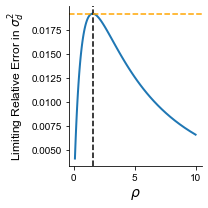

In [5]:
%%time
rhos = 10**np.linspace(-1,1, 100)
f, ax = plt.subplots(1,1, figsize=(3,3), sharex=True, sharey=True)
ax.plot(rhos, max_rel_err(rhos), lw=2)

# Analytical maximum difference in relative error
ax.axvline(3/4*np.sqrt(33) - 11/4., linestyle='--', color='black')
ax.axhline(8*(3*np.sqrt(33) - 11)/(105*np.sqrt(33) + 1991), linestyle='--', color='orange')

ax.set_ylabel(r'Limiting Relative Error in $\sigma^2_d$', fontsize=12)
ax.set_xlabel(r'$\rho$', fontsize=14)
debox(ax);
plt.tight_layout()

plt.savefig(supp_figdir + 'sigma2d_relerr_limit.pdf', dpi=300, bbox_inches='tight')

In [6]:
# Function to generate r2 as a function of genetic distance
def r2_vs_dist(ts, maf=0.1):
    gt = ts.genotype_matrix()
    af = np.mean(gt, axis=1)
    pos = np.array([s.position for s in ts.sites()])
    idx = (af > maf) & (af < (1. - maf))
    gt_filt = gt[idx,:]
    pos_filt = pos[idx]
    # calculate r^2
    r2 = np.corrcoef(gt_filt)**2
    p = pos_filt.size
    dist = np.zeros(shape=(p,p), dtype=np.float32)
    for i in range(p):
        dist[:,i] = np.sqrt((pos_filt - pos_filt[i])**2)
    idx_x, idx_y = np.tril_indices(p, k=-1)
    return(r2[idx_x,idx_y], dist[idx_x, idx_y])


# Compute the r2 vs distance filtered to specific individuals
def r2_vs_dist_filt(gt, pos, ind_idx=None, site_idx=None):
    gt = ts.genotype_matrix()
    gt_filt = gt
    pos_filt = pos
    if ind_idx is not None:
        gt_filt = gt[:,ind_idx]
    if site_idx is not None:
        pos_filt = pos[site_idx]
        gt_filt = gt_filt[site_idx,:]
    # calculate r^2
    r2 = np.corrcoef(gt_filt)**2
    p = pos_filt.size
    dist = np.zeros(shape=(p,p), dtype=np.float32)
    for i in range(p):
        dist[:,i] = np.sqrt((pos_filt - pos_filt[i])**2)
    idx_x, idx_y = np.tril_indices(p, k=-1)
    return(r2[idx_x,idx_y], dist[idx_x, idx_y])





In [12]:
n = 100
nreps = 100
seq_len = 1e6
tas = [0, 100, 1000]
nbins = 100
maf = 0.1

test_dict = {}

for t in tas:
    r2_store = np.zeros(shape=(nreps,nbins))
    dist_store = np.zeros(shape=(nreps,nbins))
    r2_store_anc = np.zeros(shape=(nreps,nbins))
    dist_store_anc = np.zeros(shape=(nreps,nbins))
    for i in tqdm(range(nreps)):
        # Running a quick test
        cur_sim = SerialConstant(Ne=1e4, mod_n=n, t_anc=[t], n_anc=[n])
        ts = cur_sim._simulate(length=seq_len, recombination_rate=1e-7, mutation_rate=1e-8)
        # Get the genotype matrix
        gt = ts.genotype_matrix()
        # doing some brief indexing
        tree = ts.first()
        times = np.array([tree.time(i) for i in tree.samples()])
        mod_idx = np.where(times == 0.)[0]
        anc_idx = np.where(times == t)[0]
        mod_af = np.mean(gt[:,mod_idx], axis=1)
        pos = np.array([s.position for s in ts.sites()])
        site_idx = (mod_af > maf) & (mod_af < (1. - maf))
        r2_vec, dist_vec = r2_vs_dist_filt(gt, pos, ind_idx=mod_idx, site_idx=site_idx)
        r2_vec_anc, dist_vec_anc = r2_vs_dist_filt(gt, pos, ind_idx=anc_idx, site_idx=site_idx)
        
        # Binning everything
        bin_means, bin_edges, binnumber = binned_statistic(dist_vec[::10], r2_vec[::10], 'mean', bins=nbins)
        bin_means_anc, bin_edges_anc, binnumber_anc = binned_statistic(dist_vec_anc[::10], r2_vec_anc[::10], 'mean', bins=nbins)

        dist_mean = (bin_edges[1:]+ bin_edges[:-1])/2.
        dist_mean_anc = (bin_edges_anc[1:]+ bin_edges_anc[:-1])/2.
        dist_store[i,:] = dist_mean
        r2_store[i,:] = bin_means
        dist_store_anc[i,:] = dist_mean_anc
        r2_store_anc[i,:] = bin_means_anc
        
    # Storing the values for later use
    test_dict[t] = (r2_store,dist_store,r2_store_anc,dist_store_anc)

 24%|██▍       | 24/100 [00:14<00:44,  1.71it/s]/home/abiddanda/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/abiddanda/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


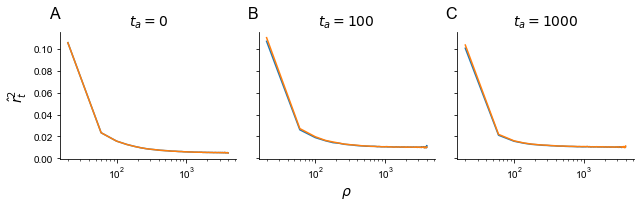

In [13]:
fig, ax = plt.subplots(1,len(tas),figsize=(3*len(tas),3), sharex=True, sharey=True)

i = 0
for t in tas:
    r2_store, dist_store, r2_store_anc, dist_store_anc = test_dict[t]
    dist_mean = np.nanmean(dist_store, axis=0)
    r2_mean = np.nanmean(r2_store, axis=0)
    
    dist_mean_anc = np.nanmean(dist_store_anc, axis=0)
    r2_mean_anc = np.nanmean(r2_store_anc, axis=0)
    
#     print(r2_mean, r2_mean_anc)
    
    rho_mean = dist_mean*1e-7*4e4
    rho_mean_anc  = dist_mean_anc*1e-7*4e4
    ax[i].plot(rho_mean_anc, r2_mean_anc, label=r'$t_a = %d$' % t) 
    ax[i].plot(rho_mean, r2_mean, label=r'$t_a = %d$' % 0)
    ax[i].set_title(r'$t_a = %d$' % t, fontsize=14)
    debox(ax[i]);
    i += 1

for i, label in enumerate(('A', 'B', 'C')):
    ax[i].text(0.0, 1.2, label, fontsize=16, 
               fontweight='bold', va='top', ha='right', transform=ax[i].transAxes);    

ax[0].set_xscale('log')
ax[0].set_ylabel(r'$\hat{r}^2_t$', fontsize=14)
ax[1].set_xlabel(r'$\rho$', fontsize=14)
plt.savefig(supp_figdir + 'sim_r2_vs_dist_and_time_split.pdf', dpi=300, bbox_inches='tight')

In [9]:
# NOTE - we probably need to setup multiple simulations here.  
# Simulating like 100 and 100?
nreps = 500
n = 100
    
tas = [0, 100,1000]
seq_len = 1e6
nbins = 100

test_dict = {}

for t in tas:
    r2_store = np.zeros(shape=(nreps,nbins))
    dist_store = np.zeros(shape=(nreps,nbins))
    
    for i in tqdm(range(nreps)):
        cur_sim = SerialConstant(Ne=1e4, mod_n=n, t_anc=[t], n_anc=[n])
        ts = cur_sim._simulate(length=seq_len, recombination_rate=1e-7, mutation_rate=1e-8)
        r2_vec, dist_vec = r2_vs_dist(ts, maf=0.1)
        bin_means, bin_edges, binnumber = binned_statistic(dist_vec[::10], r2_vec[::10], 'mean', bins=nbins)
        dist_mean = (bin_edges[1:]+ bin_edges[:-1])/2.
        dist_store[i,:] = dist_mean
        r2_store[i,:] = bin_means
        
    # Storing the values for later use
    test_dict[t] = (r2_store,dist_store)

100%|██████████| 500/500 [04:51<00:00,  1.72it/s]


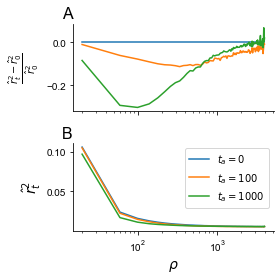

In [10]:
fig, ax = plt.subplots(2,1,figsize=(4,4), sharex=True)

# Setup the mean 0
r2_store_0, dist_store_0 = test_dict[0]
r2_mean_0 = np.mean(r2_store_0, axis=0)
dist_mean_0 = np.mean(dist_store_0, axis=0)
rho_mean_0 = dist_mean_0 * 1e-7 * 4e4

for t in tas:
    r2_store, dist_store = test_dict[t]
    dist_mean = np.mean(dist_store, axis=0)
    r2_mean = np.mean(r2_store, axis=0)
    rho_mean = dist_mean*1e-7*4e4
    ax[0].plot(rho_mean, (r2_mean-r2_mean_0)/r2_mean_0, label=r'$t_a = %d$' % t)
    ax[1].plot(rho_mean, r2_mean, label=r'$t_a = %d$' % t)

ax[1].legend()

debox(ax[0]); debox(ax[1]);

for i, label in enumerate(('A', 'B')):
    ax[i].text(0.0, 1.2, label, fontsize=16, 
               fontweight='bold', va='top', ha='right', transform=ax[i].transAxes);    


ax[0].set_ylabel(r'$\frac{\hat{r}_t^2 - \hat{r}^2_0}{\hat{r}^2_0}$', fontsize=14)
ax[1].set_ylabel(r'$\hat{r}^2_t$', fontsize=14)
ax[1].set_xlabel(r'$\rho$', fontsize=14)
ax[0].set_xscale('log')
plt.tight_layout()

plt.savefig(supp_figdir + 'sim_r2_vs_dist_and_time.pdf', dpi=300, bbox_inches='tight')